## Intro to AI Assignment 2: Predicting the popularity (retweets) of COVID-19 related tweets
### Audrey Zhang

Answers to assignment questions:
2c: The plots show that the # of followers and # of friends for the tweets in the dataset are normally distributed. The # of favorites is also somewhat similar to a normal distribution, but has a second peak at 0. This is likely caused by the large number of tweets that only had 0-1 favorites. 

The corelation matrix signifies that the # of favorites on a tweet is most highly correlated with the tweet's popularity (# retweet), with a correlation coefficient of 0.89. This is followed by the # of followers with a correlation coefficient of 0.13. 

The +/- signs indicate the direction of the correlation. + indicates positive correlation. For example, a higher # of favorites is correlated with a higher # of retweets. In contrast, - indicates negative correlation. An increase in the negative sentiment score is correlated with a lower # of retweets.

Initial data cleaning and feature creation

In [420]:
# import libraries
import numpy as np
import pandas as pd
import itertools
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [216]:
tweets=pd.read_csv('./hw2.csv')

In [3]:
tweets.head()

,Tweet ID,Username,Timestamp,#Followers,#Friends,#Retweets,#Favorites,Entities,Sentiment,Mentions,Hashtags,URLs
0,1178791787386814465,35234fe4a19cc1a3336095fb3780bcc1,Mon Sep 30 22:00:37 +0000 2019,619,770,0,0,null;,2 -1,null;,null;,null;
1,1178791985106153472,ea4592f39636d87af8fb4b17b7e2e4c0,Mon Sep 30 22:01:24 +0000 2019,36365,19344,13,17,nazi:Nazism:-2.742538749414189;blood money:Blo...,1 -4,null;,null;,https://twitter.com/himalayahawk/status/117766...
2,1178793230223183872,bf05d1888dd974fa4a8679c25e2ead03,Mon Sep 30 22:06:21 +0000 2019,5018,1933,0,0,vaccine:Vaccine:-2.6651530673745762;anti vaxxe...,2 -1,null;,null;,https://goo.gl/fb/uoeiPk:-:
3,1178795172206919680,eb8a99bca8945eab1d006750e9b75518,Mon Sep 30 22:14:04 +0000 2019,2219,971,0,0,muse:Muse_%28band%29:-2.1677823918620867;talki...,2 -1,null;,null;,null;
4,1178798309491822592,00695cf79d60e86a5d0f872f4358337a,Mon Sep 30 22:26:32 +0000 2019,9009,4943,26,89,people of northern ireland:People_of_Northern_...,2 -1,null;,VFS,null;


In [217]:
# break out sentiment variable into positive and negative
tweets['Positive']=tweets['Sentiment'].str.slice(0, 1).astype(int)
tweets['Negative']=tweets['Sentiment'].str.slice(-2).astype(int)

In [362]:
# analyze the mentions column 
men=tweets['Mentions'].dropna(axis=0).str.split()

In [363]:
# create list of lists for each item in a mention for each tweet 
mentions=[i.strip().upper() for i in list(itertools.chain.from_iterable(men.to_list())) if 'null' not in i]

In [364]:
# create a dictionary to store all mentions that appeared over 10 times
mentions_dict={x: count for x, count in Counter(mentions).items() if count >=10}

In [365]:
# take a look at the highest count mentions (top 10) and store in a list 
top_mentions=sorted(mentions_dict, key=mentions_dict.get, reverse=True)[:10]
top_mentions

['REALDONALDTRUMP',
 'JAKETAPPER',
 'BTS_TWT',
 'POTUS',
 'YOUTUBE',
 'CNN',
 'NBA',
 'SPEAKERPELOSI',
 'GOP',
 'LINDSEYGRAHAMSC']

In [352]:
# analyze the hashtag column
hsh=tweets['Hashtags'].dropna(axis=0).str.split()

In [353]:
hashtags=[i.strip().upper() for i in list(itertools.chain.from_iterable(hsh.to_list())) if 'null' not in i]

In [354]:
hashtags_dict={x: count for x, count in Counter(hashtags).items() if count >=10}

In [355]:
top_hashtags=sorted(hashtags_dict, key=hashtags_dict.get, reverse=True)[:10]
top_hashtags

['CHINA',
 'HEALTHCARE',
 'HONGKONG',
 'HONGKONGPROTESTS',
 'STANDWITHHONGKONG',
 'CHINAZI',
 'STRONGERTOGETHER',
 'ANTICHINAZI',
 'ANTIMASKLAW',
 'IMPEACHTRUMPPENCEBARRPOMPEO']

In [218]:
# create a variable for the # create variable for # of mentions for each tweet, excluding those that have 'null' in the mentions column
tweets['#Mentions']=tweets[(tweets['Mentions'].isnull()==False) & (tweets['Mentions'].str.contains('null')==False)]['Mentions'].str.split().apply(len)

In [310]:
tweets['#Mentions'].fillna(0, inplace=True)

In [220]:
tweets['#Mentions']

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
99995    1.0
99996    1.0
99997    0.0
99998    0.0
99999    0.0
Name: #Mentions, Length: 100000, dtype: float64

In [221]:
# similarly, create # of hashtags for each tweet, excluding those with 'null'
tweets['#Hashtags']=tweets[(tweets['Hashtags'].isnull()==False) & (tweets['Hashtags'].str.contains('null')==False)]['Hashtags'].str.split().apply(len)

In [311]:
tweets['#Hashtags'].fillna(0, inplace=True)

In [223]:
# check for missing values
tweets.isnull().sum()

Tweet ID        0
Username        0
Timestamp       0
#Followers      0
#Friends        0
#Retweets       0
#Favorites      0
Entities        0
Sentiment       0
Mentions      233
Hashtags       31
URLs            0
Positive        0
Negative        0
#Mentions       0
#Hashtags       0
dtype: int64

In [225]:
# for missing hashtags or tweets, fill with blank string 
tweets['Hashtags'].fillna('', inplace=True)
tweets['Mentions'].fillna('', inplace=True)

Exploratory data analysis 

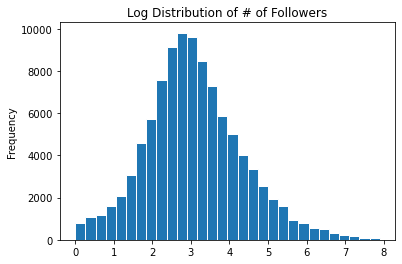

In [294]:
# plot the distribution of # of followers (log)
ax1=np.log10(tweets['#Followers']+1).plot(kind='hist', bins=30, edgecolor='w', title="Log Distribution of # of Followers")

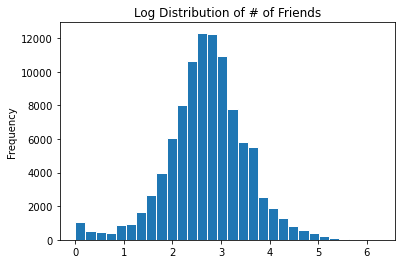

In [295]:
# distribution of # of friends (log)
np.log10(tweets['#Friends']+1).plot(kind='hist', bins=30, edgecolor='w', title='Log Distribution of # of Friends')

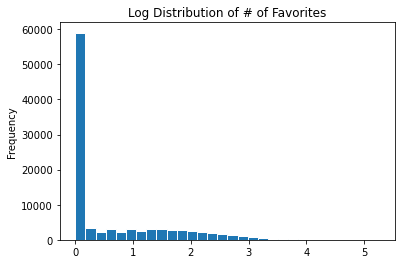

In [296]:
# distribution of # of favorites (log)
np.log10(tweets['#Favorites']+1).plot(kind='hist', bins=30, edgecolor='w', title='Log Distribution of # of Favorites')

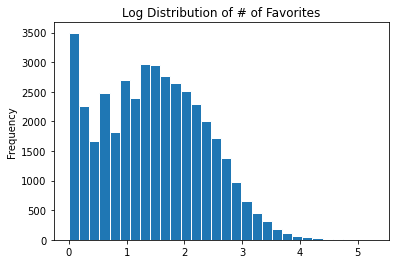

In [298]:
# distribution of # of favorites (log) without zeros 
np.log10(tweets['#Favorites'].replace(0, np.nan)).plot(kind='hist', bins=30, edgecolor='w', title='Log Distribution of # of Favorites')

In [271]:
corr=tweets[['#Favorites', '#Followers', '#Friends', 'Positive', 'Negative', '#Retweets']].corr()
corr

,#Favorites,#Followers,#Friends,Positive,Negative,#Retweets
#Favorites,1.000000,0.172158,0.017877,0.002533,-0.003889,0.890328
#Followers,0.172158,1.000000,0.011337,-0.027071,0.008711,0.134503
#Friends,0.017877,0.011337,1.000000,-0.000555,-0.007891,0.026502
Positive,0.002533,-0.027071,-0.000555,1.000000,-0.039849,0.000433
Negative,-0.003889,0.008711,-0.007891,-0.039849,1.000000,-0.010565
#Retweets,0.890328,0.134503,0.026502,0.000433,-0.010565,1.000000


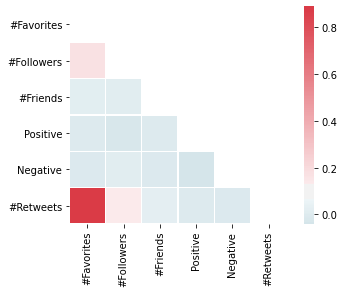

In [285]:
# visualize correlation matrix
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
#

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax.set_title('Correlation Matrix')

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0.1,
            square=True, linewidths=.3)

Further prepare the data for analysis

In [376]:
# hot encode dummy variables for top mentions
for i in top_mentions:
    tweets[i]=0
    tweets.loc[testdf['Mentions'].str.upper().str.contains(i), i]=1

In [377]:
# hot encode dummy vars for top hashtags
for i in top_hashtags:
    tweets[i]=0
    tweets.loc[testdf['Hashtags'].str.upper().str.contains(i), i]=1

In [392]:
# parse day and time information from date 
tweets['ts']=pd.to_datetime(tweets['Timestamp'])
tweets['hour']=tweets['ts'].dt.hour

In [393]:
def f(x):
    if (x > 6) and (x <= 12):
        return 'Morning'
    elif (x > 12) and (x <= 16):
        return'Afternoon'
    elif (x > 16) and (x <= 22) :
        return 'Night'
    elif (x > 22) and (x <= 24):
        return'Late Night'
    elif (x <= 4):
        return'Late Night'

tweets['time_of_day']=tweets['hour'].apply(f)

In [396]:
tweets['day']=tweets['ts'].dt.weekday

In [401]:
def d(x):
    if (x>=0) and (x<=4):
        return 'Weekday'
    elif (x>4):
        return 'Weekend'
    
tweets['day_of_wk']=tweets['day'].apply(d)

In [409]:
tweets=pd.concat([tweets, pd.get_dummies(tweets['day_of_wk']), pd.get_dummies(tweets['time_of_day'])], axis=1)

In [410]:
tweets.head()

,Tweet ID,Username,Timestamp,#Followers,#Friends,#Retweets,#Favorites,Entities,Sentiment,Mentions,...,time_of_day,ts,day,day_of_wk,Weekday,Weekend,Afternoon,Late Night,Morning,Night
0,1178791787386814465,35234fe4a19cc1a3336095fb3780bcc1,Mon Sep 30 22:00:37 +0000 2019,619,770,0,0,null;,2 -1,null;,...,Night,2019-09-30 22:00:37+00:00,0,Weekday,1,0,0,0,0,1
1,1178791985106153472,ea4592f39636d87af8fb4b17b7e2e4c0,Mon Sep 30 22:01:24 +0000 2019,36365,19344,13,17,nazi:Nazism:-2.742538749414189;blood money:Blo...,1 -4,null;,...,Night,2019-09-30 22:01:24+00:00,0,Weekday,1,0,0,0,0,1
2,1178793230223183872,bf05d1888dd974fa4a8679c25e2ead03,Mon Sep 30 22:06:21 +0000 2019,5018,1933,0,0,vaccine:Vaccine:-2.6651530673745762;anti vaxxe...,2 -1,null;,...,Night,2019-09-30 22:06:21+00:00,0,Weekday,1,0,0,0,0,1
3,1178795172206919680,eb8a99bca8945eab1d006750e9b75518,Mon Sep 30 22:14:04 +0000 2019,2219,971,0,0,muse:Muse_%28band%29:-2.1677823918620867;talki...,2 -1,null;,...,Night,2019-09-30 22:14:04+00:00,0,Weekday,1,0,0,0,0,1
4,1178798309491822592,00695cf79d60e86a5d0f872f4358337a,Mon Sep 30 22:26:32 +0000 2019,9009,4943,26,89,people of northern ireland:People_of_Northern_...,2 -1,null;,...,Night,2019-09-30 22:26:32+00:00,0,Weekday,1,0,0,0,0,1


In [432]:
#next, parse out entities 
ent=tweets['Entities'].str.split(';').copy()

In [434]:
ent

0                                                 [null, ]
1        [nazi:Nazism:-2.742538749414189, blood money:B...
2        [vaccine:Vaccine:-2.6651530673745762, anti vax...
3        [muse:Muse_%28band%29:-2.1677823918620867, tal...
4        [people of northern ireland:People_of_Northern...
                               ...                        
99995                                             [null, ]
99996    [happy birthday to you:Happy_Birthday_to_You:-...
99997                                             [null, ]
99998                                             [null, ]
99999    [prolly:Prolly:-2.50789610553847, meme:Meme:-2...
Name: Entities, Length: 100000, dtype: object

In [450]:
ent1=tweets['Entities']
ent1.str.extractall(r':(.*:)')

,,0
,match,
1,0,Nazism:-2.742538749414189;blood money:Blood_mo...
2,0,Vaccine:-2.6651530673745762;anti vaxxer:Vaccin...
3,0,Muse_%28band%29:-2.1677823918620867;talking to...
4,0,People_of_Northern_Ireland:-2.3069923615516066...
5,0,CNN:
...,...,...
99991,0,Men_who_have_sex_with_men:-2.381092681249366;r...
99992,0,Flying_ace:-1.1031571587831288;jean navarre:Je...
99993,0,Make_It_Happen_%28Mariah_Carey_song%29:


In [451]:
tweets['#Entities']=0
tweets.loc[tweets['Entities'].str.contains('null')==False, '#Entities']=tweets['Entities'].str.count(';')

In [448]:
tweets[['#Entities', 'Entities']]

,#Entities,Entities
0,0,null;
1,2,nazi:Nazism:-2.742538749414189;blood money:Blo...
2,3,vaccine:Vaccine:-2.6651530673745762;anti vaxxe...
3,2,muse:Muse_%28band%29:-2.1677823918620867;talki...
4,2,people of northern ireland:People_of_Northern_...
...,...,...
99995,0,null;
99996,1,happy birthday to you:Happy_Birthday_to_You:-1...
99997,0,null;
99998,0,null;


In [378]:
# drop mention and hashtag variables, along with url and sentiment  
cleaned_tweets=tweets.drop(['Hashtags', 'Mentions', 'Tweet ID', 'Username', 'Sentiment', 'URL', 'day_of_wk', 'time_of_day', 'hour', 'day', 'ts']).copy()

Index(['Tweet ID', 'Username', 'Timestamp', '#Followers', '#Friends',
       '#Retweets', '#Favorites', 'Entities', 'Sentiment', 'Mentions',
       'Hashtags', 'URLs', 'Positive', 'Negative', '#Mentions', '#Hashtags',
       'REALDONALDTRUMP', 'JAKETAPPER', 'BTS_TWT', 'POTUS', 'YOUTUBE', 'CNN',
       'NBA', 'SPEAKERPELOSI', 'GOP', 'LINDSEYGRAHAMSC', 'CHINA', 'HEALTHCARE',
       'HONGKONG', 'HONGKONGPROTESTS', 'STANDWITHHONGKONG', 'CHINAZI',
       'STRONGERTOGETHER', 'ANTICHINAZI', 'ANTIMASKLAW',
       'IMPEACHTRUMPPENCEBARRPOMPEO'],
      dtype='object')